In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import logging
from tqdm import tqdm

import numpy as np
from scipy import interpolate
from astropy.io import fits
#import jax.numpy as jnp

sys.path.append(os.environ['DM21CM_DIR'])
import dm21cm.physics as phys
# from dm21cm.data_loader import load_data
# from dm21cm.dm_params import DMParams
# from dm21cm.evolve import get_z_edges

sys.path.append(os.environ['DH_DIR'])
from darkhistory.spec.spectrum import Spectrum
from darkhistory.main import evolve as dh_evolve
from darkhistory.config import load_data as dh_load_data
import darkhistory.physics as dh_phys

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file("../matplotlibrc")

## 1. compare HED

### 1.1 DH on grid

In [2]:
dh_dep_tf = dh_load_data('dep_tf')['highengdep']

****** Loading transfer functions... ******
Using data at /zfs/yitians/darkhistory/DHdata_alt
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******


In [7]:
dh_xH_arr = dh_dep_tf.x[0][:,0,0]
dh_xHe_arr = dh_dep_tf.x[0][0,:,1]
dh_rs_arr = dh_dep_tf.rs[0]

i_xH = 1
i_xHe = 1
i_rs = 4
i_E = 300

xH = dh_xH_arr[i_xH]
xHe = dh_xHe_arr[i_xHe]
rs = dh_rs_arr[i_rs]

print(xH, xHe, rs)

0.009951801866904308 0.0007856685684398137 6.793051330746054


In [6]:
dh_dep_tf_slice = dh_dep_tf.get_val(xH, xHe, rs)
dh_dep_tf_slice[i_E]

array([ 1.75750284e-14,  1.40953776e-14,  5.67682753e-15, -2.17047803e-17])

In [8]:
hdul = fits.open('ionhist_outputs/tf_z_6.793E+00_x_9.952E-03_nBs_1.000E+00.fits')

In [9]:
hdul[1].data['HED_TF'][0, 300]

array([ 1.75750284e-14,  1.40953777e-14,  5.67682755e-15, -2.17046676e-17])

IDL agrees with DH on grid

### 1.2 DH off grid

In [10]:
i_xH = 1
i_xHe = 1
i_rs = 4
i_E = 300

xH = (dh_xH_arr[i_xH] + dh_xH_arr[i_xH+1]) / 2
xHe = (dh_xHe_arr[i_xHe] + dh_xHe_arr[i_xHe+1]) / 2
rs = np.sqrt(dh_rs_arr[i_rs] * dh_rs_arr[i_rs+1])

print(xH, xHe, rs)

0.1394466116184497 0.011008943022509184 7.257975692943122


In [11]:
dh_dep_tf_slice = dh_dep_tf.get_val(xH, xHe, rs)
dh_dep_tf_slice[i_E]

array([ 1.45276205e-14,  1.17552026e-14,  5.43907351e-14, -2.22061825e-17])

In [14]:
hdul = fits.open('ionhist_outputs/tf_z_7.258E+00_x_1.394E-01_nBs_1.000E+00.fits')

In [15]:
hdul[1].data['HED_TF'][0, 0]

array([ 1.27107982e-14,  1.02835650e-14,  6.39856587e-14, -2.05938945e-17])

can be off by 20 percent!

### 1.3 Just rs off grid

In [48]:
i_xH = 1
i_xHe = 1
i_rs = 4
i_E = 300

x_s = np.linspace(4e-5, 1-4e-5, 100)
rs = dh_rs_arr[i_rs]

print(rs)

6.793051330746054


In [49]:
dh_f_s = np.array([dh_dep_tf.get_val(x, phys.chi*x, rs)[i_E] for x in x_s])

In [50]:
print('['+'d, '.join([f'{x:.10f}' for x in x_s])+'d]')

[0.0000400000d, 0.0101402020d, 0.0202404040d, 0.0303406061d, 0.0404408081d, 0.0505410101d, 0.0606412121d, 0.0707414141d, 0.0808416162d, 0.0909418182d, 0.1010420202d, 0.1111422222d, 0.1212424242d, 0.1313426263d, 0.1414428283d, 0.1515430303d, 0.1616432323d, 0.1717434343d, 0.1818436364d, 0.1919438384d, 0.2020440404d, 0.2121442424d, 0.2222444444d, 0.2323446465d, 0.2424448485d, 0.2525450505d, 0.2626452525d, 0.2727454545d, 0.2828456566d, 0.2929458586d, 0.3030460606d, 0.3131462626d, 0.3232464646d, 0.3333466667d, 0.3434468687d, 0.3535470707d, 0.3636472727d, 0.3737474747d, 0.3838476768d, 0.3939478788d, 0.4040480808d, 0.4141482828d, 0.4242484848d, 0.4343486869d, 0.4444488889d, 0.4545490909d, 0.4646492929d, 0.4747494949d, 0.4848496970d, 0.4949498990d, 0.5050501010d, 0.5151503030d, 0.5252505051d, 0.5353507071d, 0.5454509091d, 0.5555511111d, 0.5656513131d, 0.5757515152d, 0.5858517172d, 0.5959519192d, 0.6060521212d, 0.6161523232d, 0.6262525253d, 0.6363527273d, 0.6464529293d, 0.6565531313d, 0.6666533

In [51]:
idl_f_s = np.zeros((len(x_s), 4))

for i in range(len(x_s)):
    x = x_s[i]
    with fits.open(f'ionhist_outputs/tf_z_{rs:.3E}_x_{x:.3E}_nBs_1.000E+00.fits') as hdul:
        idl_f_s[i] = hdul[1].data['HED_TF'][0, 0]

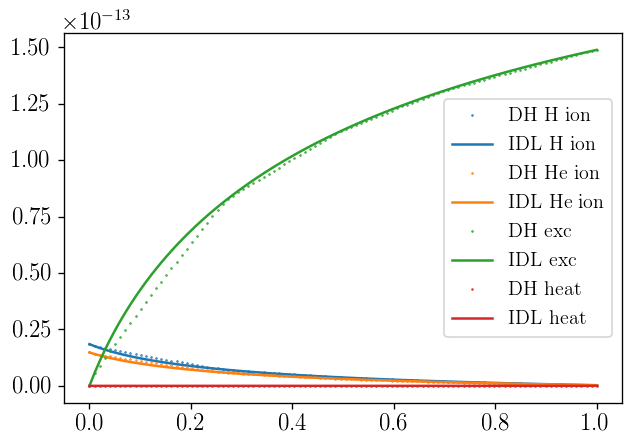

In [59]:
ch_s = ['H ion', 'He ion', 'exc', 'heat']
for i in range(4):
    plt.plot(x_s, dh_f_s[:,i], '.', color=f'C{i}', markersize=1, label=f'DH {ch_s[i]}')
    plt.plot(x_s, idl_f_s[:,i], color=f'C{i}', ls='-', label=f'IDL {ch_s[i]}')
plt.legend()

In [4]:
dep_tf = load_data(
    'phot_dep',
    prefix=os.environ['DM21CM_DATA_DIR'] + '/tf/230408x/phot',
    reload=True
)

INFO:root:Loaded photon deposition transfer function.


In [8]:
spec_N = np.zeros((500,))
spec_N[300] = 1.

In [36]:
rs = 29.97
x = 1e-2
nBs = 1

In [37]:
dep_arr = dep_tf(
    in_spec = spec_N,
    sum_result = False,
    rs = rs,
    nBs_s = jnp.array([1.]),
    x_s = jnp.array([x]),
    out_of_bounds_action = 'error',
)

In [38]:
dep_arr = np.array(dep_arr).flatten()

In [39]:
dh_dep_tf_dict = dh_load_data('dep_tf')

In [40]:
dh_dep_tf = dh_dep_tf_dict['highengdep']

In [41]:
dlnz = 0.001
dt = dlnz / phys.hubble(rs)
np.dot(spec_N, dh_dep_tf.get_val(x, phys.chi*x, rs)) * dt

array([ 3.80647822,  3.00855731,  1.03341883, -0.01559652])

In [42]:
dep_arr[:4]/(0.04879016/0.001)

array([4.338409  , 0.07210897, 3.5534062 , 4.436583  ], dtype=float32)

## check generated fits file

In [45]:
from astropy.io import fits

In [46]:
hdul = fits.open('tf_z_2.997E+01_x_1.000E-02_nBs_1.006E+00.fits')

In [54]:
dh_tf = dh_dep_tf.get_val(x, phys.chi*x, rs)

In [52]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL+1)

In [56]:
hdul[1].data['HED_TF'][0,:,3]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

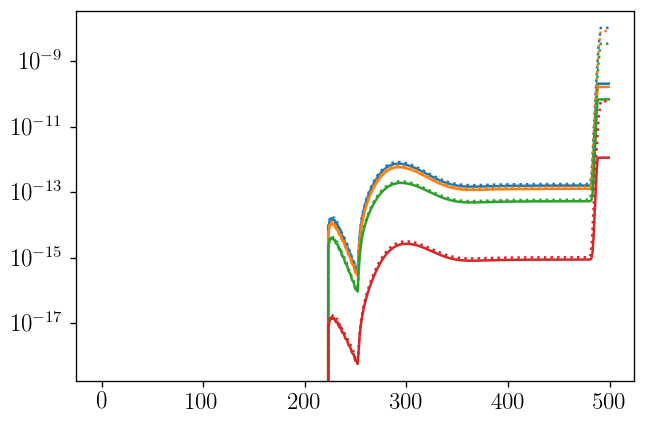

In [57]:
for i in range(4):
    plt.plot(np.abs(hdul[1].data['HED_TF'][0,:,i]), color=f'C{i}')
    plt.plot(np.abs(dh_tf[:,i]), color=f'C{i}', ls=':')
plt.yscale('log')

In [ ]:
abscs_name = 'abscs_230408x'
abscs = {
    'rs' : np.logspace(np.log10(5), np.log10(50), 10),
    'x' : np.array([1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.3, 0.7, 0.9, 1-1e-3, 1-1e-5]),
    'nBs' : np.array([0.001, 0.262, 0.708, 0.818, 0.888, 0.944, 1.006, 1.102, 4.855, 10.]),
    'photE' : photE_DH(n=500),
    'elecEk' : elecEk_DH(n=500),
    'dep_c' : ['H ion', 'He ion', 'exc', 'heat', 'cont', 'xray'],
    'dlnz' : 0.04879016,
}